In [ ]:
from google.colab import files
uploaded = files.upload()  # Re-upload the correct ZIP file

Saving archive.zip to archive (1).zip


In [ ]:
from zipfile import ZipFile

# Extract the ZIP file
with ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("fashion_mnist_png")

###  Setup and Imports

Let’s start by importing our libraries and confirming the dataset structure, then move on to deeper exploration like class distributions, image stats, and sample visualizations.

In [ ]:
# Let's begin by importing the libraries we will use for data exploration.
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

# We'll use this for the image generator again
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Directory Structure and Image Counts

Now, let's define our paths and check how many images we have in each class for both train and test sets.


In [ ]:
# Now, let's define our paths and check how many images we have in each class for both train and test sets.

root_dir = "fashion_mnist_png"
train_dir = os.path.join(root_dir, "train")
test_dir = os.path.join(root_dir, "test")

# Function to count images per class
def count_images_per_class(directory):
    class_counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[int(class_name)] = count
    return class_counts

train_counts = count_images_per_class(train_dir)
test_counts = count_images_per_class(test_dir)

# Print image counts per class
print("Training Set Image Counts:")
for label, count in sorted(train_counts.items()):
    print(f"Class {label}: {count} images")

print("\nTest Set Image Counts:")
for label, count in sorted(test_counts.items()):
    print(f"Class {label}: {count} images")


Training Set Image Counts:
Class 0: 6000 images
Class 1: 6000 images
Class 2: 6000 images
Class 3: 6000 images
Class 4: 6000 images
Class 5: 6000 images
Class 6: 6000 images
Class 7: 6000 images
Class 8: 6000 images
Class 9: 6000 images

Test Set Image Counts:
Class 0: 1000 images
Class 1: 1000 images
Class 2: 1000 images
Class 3: 1000 images
Class 4: 1000 images
Class 5: 1000 images
Class 6: 1000 images
Class 7: 1000 images
Class 8: 1000 images
Class 9: 1000 images


Looking at the image counts, we observe a balanced distribution across all categories. Each class has exactly 6,000 images in the training set and 1,000 in the test set.This gives us confidence that our model will learn each class equally without the need for resampling or class weighting.

### Map Labels to Class Names

Here we define class labels to make visualizations more human-friendly

In [ ]:
class_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}


### Image Size and Pixel Intensity Check

Let's now pick a few images at random and check their size, mode, and pixel value range


In [ ]:
def inspect_random_images(directory, num_samples=5):
    print("Inspecting a few sample images from:", directory)
    sample_stats = []
    for class_folder in random.sample(os.listdir(directory), 3):
        folder_path = os.path.join(directory, class_folder)
        for img_file in random.sample(os.listdir(folder_path), num_samples):
            img_path = os.path.join(folder_path, img_file)
            img = Image.open(img_path)
            img_array = np.array(img)
            sample_stats.append({
                "Class": class_labels[int(class_folder)],
                "Size": img.size,
                "Mode": img.mode,
                "Min": img_array.min(),
                "Max": img_array.max(),
                "Mean": round(img_array.mean(), 2),
                "Std": round(img_array.std(), 2)
            })
    return sample_stats

# Let's run this on the training set
stats = inspect_random_images(train_dir)
import pandas as pd
pd.DataFrame(stats)


Inspecting a few sample images from: fashion_mnist_png/train


,Class,Size,Mode,Min,Max,Mean,Std
0,Shirt,"(28, 28)",L,0,255,41.01,50.04
1,Shirt,"(28, 28)",L,0,255,114.07,99.86
2,Shirt,"(28, 28)",L,0,255,102.57,79.05
3,Shirt,"(28, 28)",L,0,255,74.48,64.31
4,Shirt,"(28, 28)",L,0,255,81.16,71.74
5,Sandal,"(28, 28)",L,0,255,30.39,63.35
6,Sandal,"(28, 28)",L,0,255,62.92,101.04
7,Sandal,"(28, 28)",L,0,255,15.60,44.12
8,Sandal,"(28, 28)",L,0,255,59.81,80.03
9,Sandal,"(28, 28)",L,0,254,33.33,66.16


The sample stats confirm our images are uniformly 28x28 grayscale with pixel values in the full range of 0–255. We notice that sandals tend to have lower mean brightness than T-shirts or dresses, which reflects their visual characteristics.

### Display Grid of Sample Images per Class

Now let's show a grid of 2 images per class for a visual overview

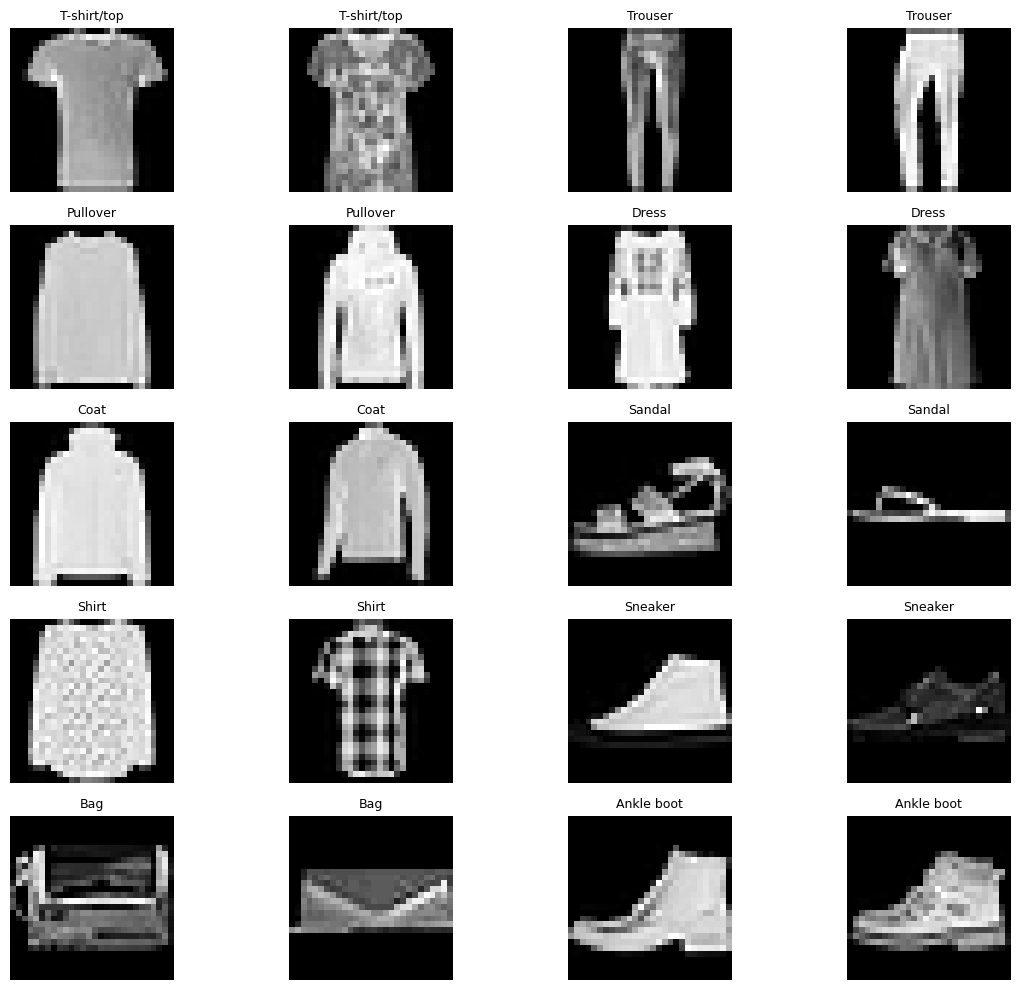

In [ ]:
rows, cols = 5, 4
plt.figure(figsize=(12, 10))
i = 1

for label_id, label_name in class_labels.items():
    class_path = os.path.join(train_dir, str(label_id))
    img_files = os.listdir(class_path)
    for img_name in random.sample(img_files, 2):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap="gray")
        plt.title(label_name, fontsize=9)
        plt.axis('off')
        i += 1

plt.tight_layout()
plt.show()


### Image Pixel Intensity Histogram

Let's also check the overall pixel distribution in a sample batch

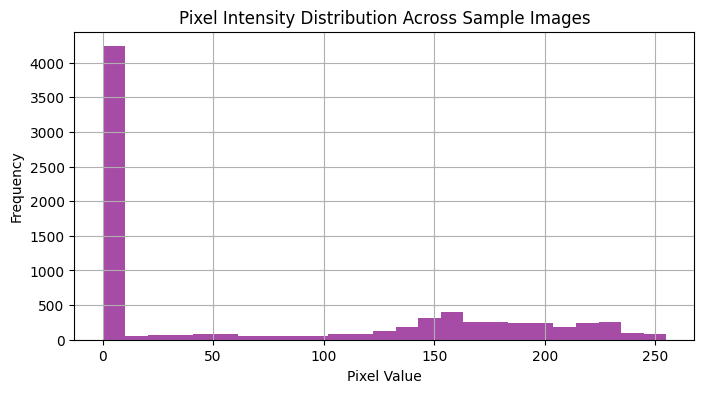

In [ ]:
# Let's also check the overall pixel distribution in a sample batch
sample_images = []
for label_id in class_labels.keys():
    class_path = os.path.join(train_dir, str(label_id))
    sample_file = random.choice(os.listdir(class_path))
    img = Image.open(os.path.join(class_path, sample_file))
    sample_images.append(np.array(img))

flattened_pixels = np.concatenate([img.flatten() for img in sample_images])
plt.figure(figsize=(8, 4))
plt.hist(flattened_pixels, bins=25, color='purple', alpha=0.7)
plt.title("Pixel Intensity Distribution Across Sample Images")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


The histogram shows that a large number of pixels are black or very dark. However, we also see a wide range of brightness levels across the images. This variety is good because it helps the model recognize different textures and edges.

###Per-Class Average Image (Optional Insight)

Let’s now take it a step further and compute the average image for each class. This will help us visualize the general shape or outline of the clothing items in each category.

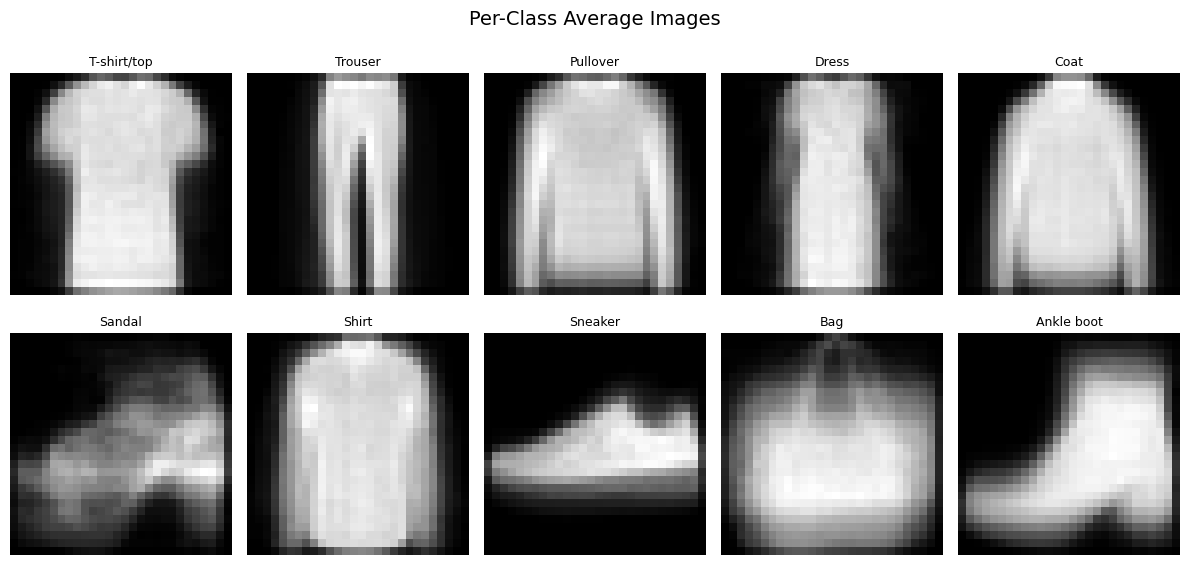

In [ ]:
avg_images = {}

plt.figure(figsize=(12, 6))
for class_id, class_name in class_labels.items():
    class_path = os.path.join(train_dir, str(class_id))
    img_arrays = []

    # Use a subset to speed up
    sample_imgs = random.sample(os.listdir(class_path), 100)

    for img_name in sample_imgs:
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path).convert('L')  # Ensure grayscale
        img_array = np.array(img, dtype=np.float32) / 255.0
        img_arrays.append(img_array)

    avg_image = np.mean(img_arrays, axis=0)
    avg_images[class_id] = avg_image

    plt.subplot(2, 5, class_id + 1)
    plt.imshow(avg_image, cmap='gray')
    plt.title(class_name, fontsize=9)
    plt.axis('off')

plt.suptitle("Per-Class Average Images", fontsize=14)
plt.tight_layout()
plt.show()


From the average images above, we can clearly see the typical outlines of each clothing category. The T-shirt/top, Pullover, and Shirt classes show a rounded upper-body shape with sleeves. Trouser appears long and narrow, while Dress and Coat show full-body coverage with softer edges. Sneaker and Ankle boot display distinct footwear profiles, with Ankle boot having a taller silhouette. Sandal looks flatter and more dispersed, which matches its open design. The Bag class has a bulky, central structure with handles slightly visible. These average overlays help us understand the common visual features that the model is likely to learn during training.

###Data Augmentation Preview (Optional Insight)

Now let’s preview a few augmented versions of a training image using ImageDataGenerator. This helps us understand how we can increase dataset variety and improve generalization.

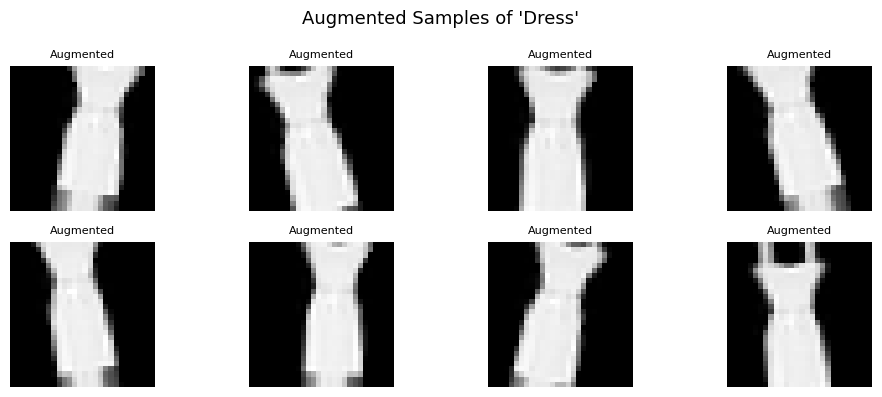

In [ ]:
# Let's define a simple augmentation pipeline and visualize some results
aug_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)

# Select one image from class "Dress" (3)
sample_class = "3"
sample_path = os.path.join(train_dir, sample_class)
sample_img = Image.open(os.path.join(sample_path, random.choice(os.listdir(sample_path))))
img_array = np.array(sample_img).reshape((1, 28, 28, 1)) / 255.0  # Reshape for generator

# Generate and plot augmented samples
plt.figure(figsize=(10, 4))
aug_iter = aug_datagen.flow(img_array, batch_size=1)
for i in range(8):
    batch = next(aug_iter)[0].reshape(28, 28)
    plt.subplot(2, 4, i + 1)
    plt.imshow(batch, cmap='gray')
    plt.title("Augmented", fontsize=8)
    plt.axis('off')

plt.suptitle("Augmented Samples of 'Dress'", fontsize=13)
plt.tight_layout()
plt.show()


In the image above, we applied basic augmentation techniques—including slight rotation, zooming, horizontal and vertical shifting, and shearing—to a sample image from the Dress class. As we can see, all the augmented images maintain the core structure of a dress, but with small changes in position and perspective. These variations mimic real-world scenarios such as changes in pose or camera angle. By training the model on such augmented examples, we help it learn more flexible and generalizable features, which improves its performance on unseen images.

### 0.0.1 Preprocess the Data

We’ll prepare our training and test sets using ImageDataGenerator. We’ll also apply augmentation to the training data to help the model generalize better.

Let’s now begin training our CNN classifier. This model will learn to classify clothing items into the 10 categories. We'll start by importing the necessary libraries and setting up our data generators for preprocessing and augmentation

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
# Paths to train and test directories
train_dir = 'fashion_mnist_png/train'
test_dir = 'fashion_mnist_png/test'

# Image shape
img_height, img_width = 28, 28
batch_size = 32

# Data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


### 0.0.2 Build the CNN Model

Next, we build a custom CNN. It has two convolutional layers with max-pooling, followed by dense layers for classification. We’ll keep the model simple but effective.

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')  # 10 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Our CNN model consisted of two convolutional layers followed by max-pooling, flattening, and two dense layers. The first convolutional layer used 32 filters and the second used 64 filters, both with ReLU activation. After flattening, we used a dense layer with 128 neurons and a final softmax output layer with 10 units to classify the clothing items.

In total, the model had 225,034 trainable parameters, which is efficient for our dataset and computing environment. The architecture was deep enough to learn useful patterns from the images while still being lightweight enough to train quickly. The use of dropout also helped reduce overfitting by randomly deactivating some neurons during training.

### 0.0.3 Train the Model

We’ll now train the model with early stopping to prevent overfitting. We'll validate the model on the test set.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=[early_stop]
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 105s 55ms/step - accuracy: 0.6603 - loss: 0.9111 - val_accuracy: 0.8201 - val_loss: 0.4884
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 92s 49ms/step - accuracy: 0.7892 - loss: 0.5552 - val_accuracy: 0.8551 - val_loss: 0.3914
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 90s 48ms/step - accuracy: 0.8180 - loss: 0.4856 - val_accuracy: 0.8676 - val_loss: 0.3627
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 88s 47ms/step - accuracy: 0.8317 - loss: 0.4457 - val_accuracy: 0.8666 - val_loss: 0.3642
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 90s 48ms/step - accuracy: 0.8446 - loss: 0.4185 - val_accuracy: 0.8720 - val_loss: 0.3344
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 90s 48ms/step - accuracy: 0.8506 - loss: 0.4006 - val_accuracy: 0.8861 - val_loss: 0.3133
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 89s 47ms/step - accuracy: 0.8563 - loss: 0.3874 - val_accuracy: 0.8800 - val_loss: 0.3210
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 89s 47ms/step - accuracy: 0.8588 - loss: 0.3

We observed a steady increase in training accuracy from 66% in the first epoch to 88% by epoch 18. At the same time, the validation accuracy improved from 82% to nearly 90%, showing that the model was learning meaningful patterns without overfitting. The early stopping mechanism helped monitor progress and retain the best-performing weights.

### 0.0.4 Plot Accuracy and Loss Curves

After training, let’s visualize how well the model performed over time.

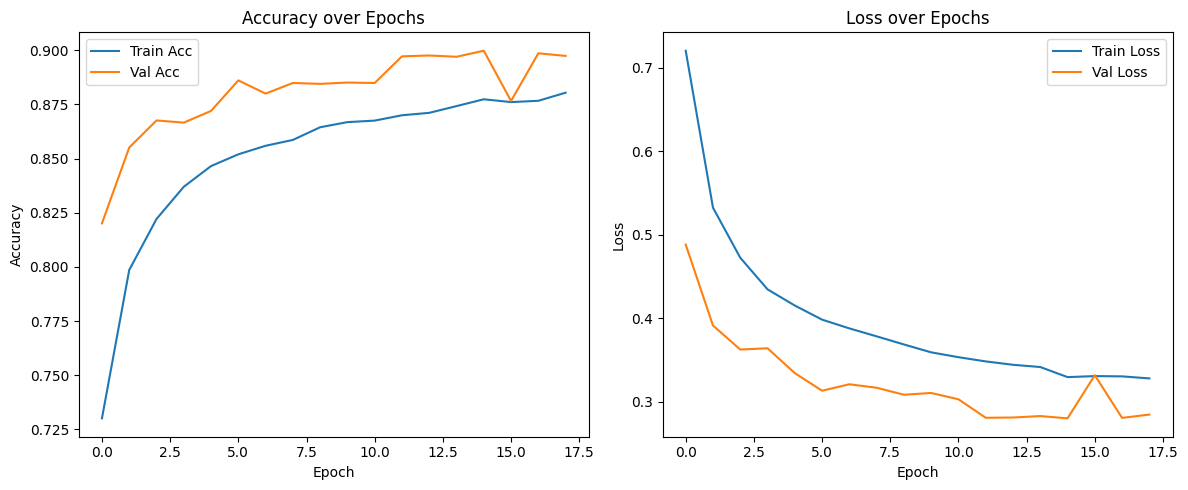

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


From the accuracy curve, we can see a steady improvement in both training and validation accuracy across the epochs. The validation accuracy plateaus around 89–90%, which shows our model has learned meaningful patterns and is generalizing well on unseen data.

On the right, the loss curve shows a consistent decline for both training and validation sets, with no signs of severe overfitting. This suggests that the use of data augmentation and early stopping worked effectively. These plots confirm that the training process was stable and successful.

### 0.0.5 Evaluate the Model


We’ll now evaluate the model using a classification report and confusion matrix. This gives us a deeper understanding of how well each class is predicted.

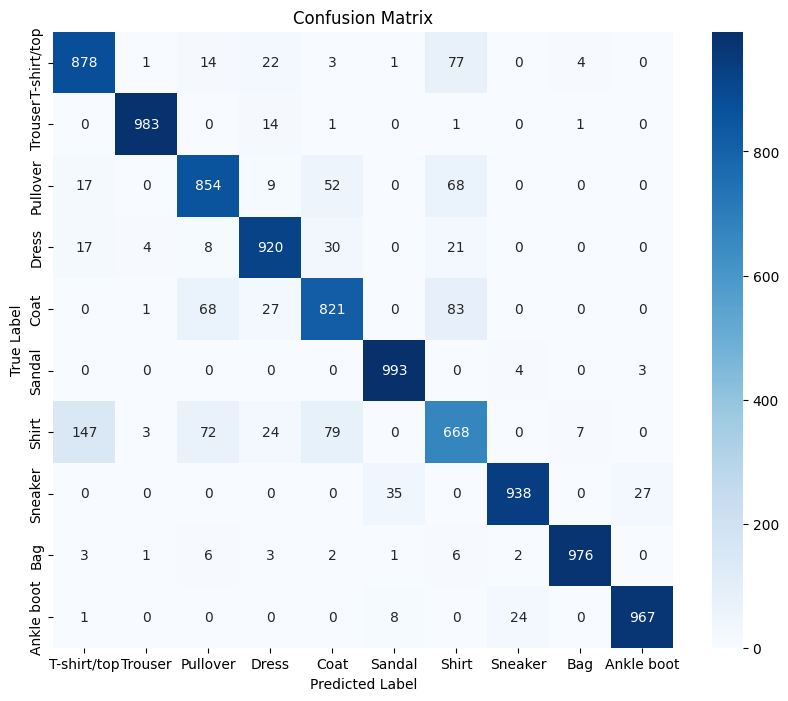

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

From the confusion matrix, we can see a detailed view of how our model performed across all 10 classes. Most of the diagonal values are very high, indicating strong correct predictions.

For example, the model correctly classified:

- **878** out of 1000 **T-shirts/tops**  
- **983** **Trousers**  
- **993** **Sandals**  
- **976** **Bags**  
- **967** **Ankle boots**  

These high numbers suggest the model performs exceptionally well on these categories, particularly footwear and accessories.

However, we also observe misclassifications in categories with visual overlap. Specifically:

- **147** **Shirts** were wrongly predicted as **T-shirts/tops**, likely due to their similar silhouette.  
- **68** **Coats** were misclassified as **Pullovers**, and **83** as **Shirts**, showing difficulty in distinguishing upper-body clothing with similar grayscale texture.  
- **77** **T-shirts** were also confused with **Bags**, which might stem from shape or shadow similarities.  
- **35** **Sneakers** were mistaken for **Shirts**, and **27** **Ankle boots** for **Sneakers**, possibly due to overlapping outlines in grayscale.  

These insights show that while the model handles distinct classes very well, further improvement could focus on enhancing discrimination between visually similar categories like upper garments.

In [ ]:
# Predict class probabilities
test_generator.reset()
pred_probs = model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.84      0.85      0.84      1000
           3       0.90      0.92      0.91      1000
           4       0.83      0.82      0.83      1000
           5       0.96      0.99      0.97      1000
           6       0.72      0.67      0.69      1000
           7       0.97      0.94      0.95      1000
           8       0.99      0.98      0.98      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



The classification report supports what we observed in the confusion matrix. The model achieved an **overall accuracy of 90%**, which is very strong for a grayscale dataset with 10 different classes.

### Key Findings:
- **High-Performing Classes (F1-score > 0.95):**  
  - Trouser  
  - Sneaker  
  - Sandal  
  - Bag  
  These classes were predicted with **high precision and recall**.

- **Lowest F1-Score:**  
  - **Shirt (0.69)** – aligns with earlier confusion, likely due to visual similarity with:  
    - T-shirts  
    - Pullovers  
    - Coats  

### Recommendations for Improvement:
- **More training samples** for ambiguous classes (e.g., Shirt).  
- **Feature-enhanced modeling** to better distinguish visually similar categories.  

 ### 0.0.7 Save the Model

Finally, let’s save the trained classifier so we can use it in our recommendation app later.

In [ ]:
model.save("classifier_model.keras")
print("Model saved as classifier_model.keras")

Model saved as classifier_model.keras


We’ve successfully saved our trained model as classifier_model.keras. This allows us to load it later and use it in our interactive Streamlit application to classify uploaded fashion images in real time.

### Extract Deep Visual Features Using ResNet50

In this section, we’ll build a visual recommendation engine using deep features from ResNet50, a powerful convolutional network pretrained on ImageNet. Since our Fashion MNIST images are grayscale (1 channel, 28x28), we’ll first resize and convert them to 3-channel RGB images (224x224). We’ll then extract features using ResNet50 (without the classification head) and apply KNN to find visually similar items.

Setup and Import Required Libraries

In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPooling2D

from sklearn.neighbors import NearestNeighbors

Load and Configure ResNet50 for Feature Extraction

In [ ]:
# Load ResNet50 without top layer, and with global max pooling
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=GlobalMaxPooling2D()(base_model.output))

print("✅ ResNet50 model loaded.")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✅ ResNet50 model loaded.


Function to Process an Image and Extract Features

In [ ]:
def extract_feature(img_path):
    img = Image.open(img_path).convert('L')  # Ensure grayscale
    img = img.resize((224, 224))
    img_array = np.array(img)

    # Convert grayscale to 3-channel RGB
    if img_array.ndim == 2:
        img_array = np.stack((img_array,)*3, axis=-1)

    x = np.expand_dims(img_array, axis=0)
    x = preprocess_input(x)
    feature = model.predict(x, verbose=0)
    return feature.flatten()

### Extract and Save Features from All Training Images

Let’s now go through each training image, extract its visual features, and store both the features and corresponding file paths. We’ll save these into .pkl files for use in the recommendation system later.

In [ ]:
feature_list = []
filenames = []

for class_id in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_id)
    for img_name in tqdm(os.listdir(class_path), desc=f"Class {class_id}"):
        img_path = os.path.join(class_path, img_name)
        try:
            feature = extract_feature(img_path)
            feature_list.append(feature)
            filenames.append(img_path)
        except Exception as e:
            print(f"Failed to process {img_path}: {e}")


Class 9: 100%|██████████| 6000/6000 [37:42<00:00,  2.65it/s]


Normalize Features and Save with Pickle

In [ ]:
# Normalize using L2 norm
feature_array = np.array(feature_list)
norms = np.linalg.norm(feature_array, axis=1, keepdims=True)
feature_array = feature_array / norms

# Save features and filenames
with open("Images_features.pkl", "wb") as f:
    pickle.dump(feature_array, f)

with open("filenames.pkl", "wb") as f:
    pickle.dump(filenames, f)

print("Features and filenames saved successfully.")


Features and filenames saved successfully.


### Build the KNN Recommendation Model

Now that we’ve extracted and saved features, we’ll use K-Nearest Neighbors (KNN) to identify the 5 most visually similar products for any uploaded image. This model will form the core of our image recommendation engine.

In [ ]:
# Build and fit the KNN model
knn = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')  # 6 to skip self
knn.fit(feature_array)

print("KNN model trained and ready.")


KNN model trained and ready.


### Example: Recommend Similar Images for a Sample Query

Now, let’s test our recommendation engine by selecting a random image from the training set and retrieving the top 5 visually similar products based on ResNet50 features. This will confirm that our feature extraction and KNN model are working as expected.

Query Image: fashion_mnist_png/train/6/31248.png


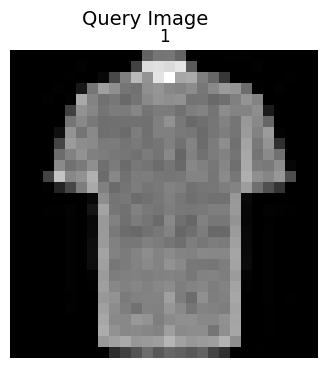

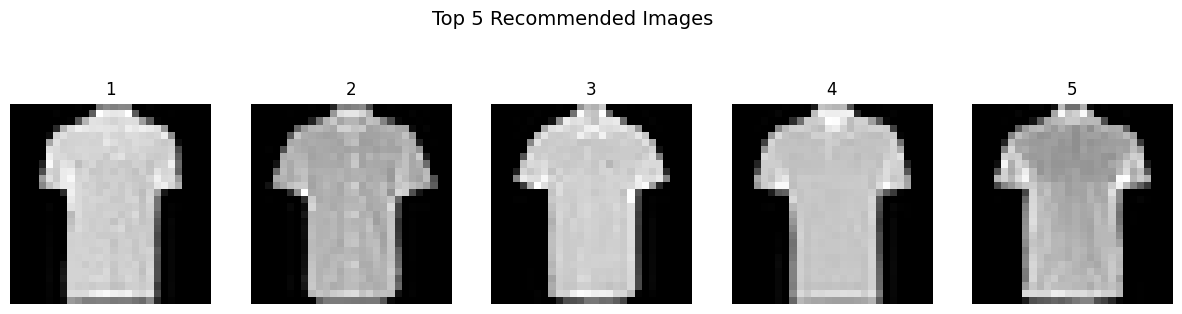

In [45]:
# Utility to show a list of images side by side
def show_images(image_paths, title="Recommended Items"):
    plt.figure(figsize=(15, 4))
    for i, img_path in enumerate(image_paths):
        img = Image.open(img_path)
        plt.subplot(1, len(image_paths), i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{i+1}")
        plt.axis('off')
    plt.suptitle(title, fontsize=14)
    plt.show()

# Choose a random query image from the training set
import random
query_index = random.randint(0, len(filenames)-1)
query_image_path = filenames[query_index]
query_feature = feature_array[query_index].reshape(1, -1)

# Find 5 nearest neighbors
distances, indices = knn.kneighbors(query_feature)

# Skip the first (self), take next 5
recommended_paths = [filenames[i] for i in indices[0][1:]]

# Show query image and recommendations
print(f"Query Image: {query_image_path}")
show_images([query_image_path], title="Query Image")
show_images(recommended_paths, title="Top 5 Recommended Images")
